In [1]:
from timeit import default_timer as timer
import time
from datetime import date
import os
import sys
import uuid
from glob import glob
import json
import tweepy
import numpy as np
import pandas as pd

In [2]:
countries_short = ['US'] # ['AR', 'BR', 'CD', 'CO', 'FR', 'MX', 'NG', 'PK', 'US', 'VE']
pull_type = 'update' # ['full','update']
drop_seeds = False
max_timestamp = '12/31/2022' # '9/1/2022'
min_timestamp = '04/01/2022' # '1/1/2019'
path_to_data = "/scratch/spf248/twitter_data_collection/data"
path_to_output = "/scratch/spf248/twitter_data_collection/data"
start_pull = date.today().strftime("%d%m%Y")
id_type = 'user_id'
max_users_per_app = 15
apps = ['spfraib_sentiments','WorldBankGroup6'] # ['spfraib_sentiments','WorldBankGroup6']
max_requests = 880
window_in_sec = 900
wait_in_sec = 10

print('countries_short:',countries_short)
print('pull_type:',pull_type)
print('drop_seeds:',drop_seeds)
print('max_timestamp:',max_timestamp)
print('min_timestamp:',min_timestamp)
print('path_to_data:',path_to_data)
print('path_to_output:',path_to_output)
print('start_pull:',start_pull)
print('id_type:',id_type)
print('Max auth of',max_users_per_app,'users per app')
print('Apps:',apps)
print('Store after',max_requests,'requests')
print('Window of',window_in_sec,'sec to replenish rate limits')
print('Wait',wait_in_sec,'sec to replenish rate limits')

countries_short: ['US']
pull_type: update
drop_seeds: False
max_timestamp: 12/31/2022
min_timestamp: 04/01/2022
path_to_data: /scratch/spf248/twitter_data_collection/data
path_to_output: /scratch/spf248/twitter_data_collection/data
start_pull: 25122022
id_type: user_id
Max auth of 15 users per app
Apps: ['spfraib_sentiments', 'WorldBankGroup6']
Store after 880 requests
Window of 900 sec to replenish rate limits
Wait 10 sec to replenish rate limits


In [3]:
def select_key_files(path_to_data,max_users_per_app,apps):
    key_files = []
    key_usernames = []
    app2username = {}
    all_files = sorted(glob(os.path.join(path_to_data,'../keys','v1','*.json')))
    for file in all_files:
        username = file.split('/')[-1].split('-')[1].split('.json')[0]
        app = file.split('/')[-1].split('-')[0]
        app2username.setdefault(app, [])
        if app in apps and username not in key_usernames and len(app2username[app])<max_users_per_app and 'bot' not in username:
            app2username[app].append(username)
            key_files.append(file)
            key_usernames.append(username)
    return key_files

key_files = select_key_files(path_to_data,max_users_per_app,apps)
print('key files:', len(key_files))

key files: 30


In [4]:
def get_env_var(varname,default):
    if os.environ.get(varname) != None:
        var = int(os.environ.get(varname))
        print(varname,':', var)
    else:
        var = default
        print(varname,':', var,'(Default)')
    return var

# Choose Number of Nodes To Distribute Credentials: e.g. jobarray=0-4, cpu_per_task=20, credentials = 90 (<100)
SLURM_JOB_ID            = get_env_var('SLURM_JOB_ID',0)
SLURM_ARRAY_TASK_ID     = get_env_var('SLURM_ARRAY_TASK_ID',10)
SLURM_ARRAY_TASK_COUNT  = get_env_var('SLURM_ARRAY_TASK_COUNT',len(key_files))

SLURM_JOB_ID : 28570912
SLURM_ARRAY_TASK_ID : 10 (Default)
SLURM_ARRAY_TASK_COUNT : 30 (Default)


In [5]:
print('Load and select users:')
start = timer()
files = pd.Series(sorted(glob(os.path.join(path_to_data,'user_timeline','batch','*.parquet')))).sample(frac=1,random_state=0).to_list()
files_node = list(np.array_split(files,SLURM_ARRAY_TASK_COUNT)[SLURM_ARRAY_TASK_ID])
users_node = pd.read_parquet(files_node)

# Keep users associated with selected countries (duplicates occur when users are associated with multiple countries)
users = users_node[users_node['country_short'].isin(countries_short)].copy()
print('# users:', len(users))

if pull_type == 'full':
    users = users[users['tweet_timestamp'].isnull()]
    print('keep full timelines...')
    print('# users:', len(users))
elif pull_type == 'update':
    users = users[-users['tweet_timestamp'].isnull()]
    print('keep updated timelines...')
    print('# users:', len(users))
    if max_timestamp:
        users = users[(users['tweet_timestamp']<max_timestamp)]
        print('max_timestamp...')
        print('# users:', len(users))
    if min_timestamp:
        users = users[(users['tweet_timestamp']>min_timestamp)]
        print('min_timestamp...')
        print('# users:', len(users))
if drop_seeds:
    users = users[users['is_seed']==0]
    print('drop_seeds...')
    print('# users:', len(users))
users = users.drop_duplicates('user_id').sort_values(by='user_id').sample(frac=1,random_state=0).reset_index(drop=True)
print('drop duplicates...')
print('# users:', len(users))

end = timer()
print('Computing Time:', round(end - start), 'sec')

Load and select users:
# users: 1288283
keep updated timelines...
# users: 1057865
max_timestamp...
# users: 1057865
min_timestamp...
# users: 267158
drop duplicates...
# users: 267158
Computing Time: 5 sec


In [6]:
users.head()

,user_id,country_short,tweet_id,tweet_timestamp,is_seed
0,416515819,US,1559768494845005825,2022-08-17 05:06:02,1
1,3245351730,US,1559923083816960000,2022-08-17 15:20:19,0
2,1004233324812890112,US,1559412098220044289,2022-08-16 05:29:51,0
3,1705771326,US,1558468351030181888,2022-08-13 14:59:44,0
4,305926954,US,1558908619457843200,2022-08-14 20:09:12,1


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267158 entries, 0 to 267157
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          267158 non-null  object        
 1   country_short    267158 non-null  object        
 2   tweet_id         267158 non-null  object        
 3   tweet_timestamp  267158 non-null  datetime64[ns]
 4   is_seed          267158 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 9.2+ MB


<AxesSubplot:xlabel='tweet_timestamp'>

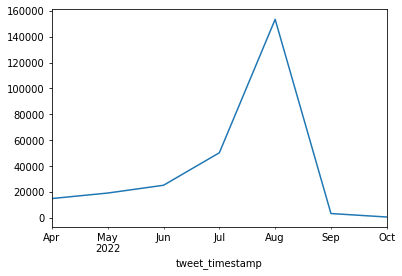

In [8]:
users.set_index('tweet_timestamp').resample('M')['user_id'].count().truncate(before='7/1/2019').plot()

In [9]:
def get_key_file(key_files,SLURM_ARRAY_TASK_ID,SLURM_ARRAY_TASK_COUNT):
    print('# keys:', len(key_files))
    if SLURM_ARRAY_TASK_COUNT!=len(key_files) or SLURM_ARRAY_TASK_ID>=len(key_files) or SLURM_ARRAY_TASK_ID<0:
        print("CHECK JOBARRAY")
    return key_files[SLURM_ARRAY_TASK_ID]
        
key_file = get_key_file(key_files,SLURM_ARRAY_TASK_ID,SLURM_ARRAY_TASK_COUNT)
print('key file:', key_file)

# keys: 30
key file: /scratch/spf248/twitter_data_collection/data/../keys/v1/WorldBankGroup6-dunstan.json


In [10]:
def get_API_auth(key_file):
    # Import Key
    with open(key_file) as f:
        key = json.load(f)
    # OAuth process, using the keys and tokens
    auth = tweepy.OAuthHandler(key['consumer_key'], key['consumer_secret'])
    auth.set_access_token(key['access_token'], key['access_token_secret'])
    # Creation of the actual interface, using authentication
    api_auth = tweepy.API(auth,wait_on_rate_limit=True)
    try:
        api_auth.verify_credentials()
    except:
        sys.exit(key_file,": error during authentication")
    return api_auth

# for key_file in glob(os.path.join(path_to_data,'../keys','v1',app+'*.json')):
#     get_API_auth(key_file)
# print('Credentials Checked!')

# Create API auth
api = get_API_auth(key_file)

In [11]:
def n_requests_for_full_timeline(user_timeline,count=200):
    if user_timeline.shape[0]:
        return user_timeline.shape[0]//count+(user_timeline.shape[0]%count>0)
    else:
        return 1

def pull_from_user_timeline_API_endpoint(api,user,id_type,since_id):
    user_timeline=[]
    error=None
    try:
        if since_id:
            if id_type == 'user_id':
                cursor=tweepy.Cursor(api.user_timeline,user_id=user,since_id=since_id,count=200,tweet_mode="extended",include_rts=True).items()
            elif id_type == 'screen_name':
                cursor=tweepy.Cursor(api.user_timeline,screen_name=user,since_id=since_id,count=200,tweet_mode="extended",include_rts=True).items()
        else:
            if id_type == 'user_id':
                cursor=tweepy.Cursor(api.user_timeline,user_id=user,count=200,tweet_mode="extended",include_rts=True).items()
            elif id_type == 'screen_name':
                cursor=tweepy.Cursor(api.user_timeline,screen_name=user,count=200,tweet_mode="extended",include_rts=True).items()
        for status in cursor:
            user_timeline.append(status._json)
    except tweepy.errors.TweepyException as e:
        error = str(e)
    return pd.DataFrame(user_timeline), error

# timeline_test_1,error = pull_from_user_timeline_API_endpoint(api,'@deaneckles','screen_name','1388683708195086336')
# timeline_test_2,error = pull_from_user_timeline_API_endpoint(api,'@deaneckles','screen_name',None)

In [12]:
def pull_and_store(country_short):
    n_users_queried = 0
    n_users_pulled = 0
    n_users_error = 0
    users_tmp = users[(users['country_short']==country_short)]
    users_tmp = users_tmp[users_tmp['tweet_id'].isnull()=={'full':True,'update':False}[pull_type]]
    users_tmp = users_tmp[['user_id','tweet_id']].to_records(index=False)
    print('# users:',len(users_tmp))
    print()
    output_id = str(uuid.uuid4())
    tweets_window = pd.DataFrame()
    n_tweets_window = 0
    n_requests_window = 0
    n_users_window = 0
    start = timer()
    for user_id,tweet_id in users_tmp:
        n_users_queried += 1
        tweets_user, error = pull_from_user_timeline_API_endpoint(api,user_id,id_type,tweet_id)
        if not error:
            tweets_window = pd.concat([tweets_window, tweets_user],sort=False)
            n_tweets_window += tweets_user.shape[0]
            n_requests_window += n_requests_for_full_timeline(tweets_user)
            n_users_window += 1
            n_users_pulled += 1
        else:
            n_users_error += 1
#             print('Error pulling user',n_users_queried,':',error)
        if n_users_queried and not n_users_queried % 100:
            print('# queried users:',n_users_queried)
            print('# pulled users:',n_users_pulled)
            print('# pulled missed:',n_users_error)
            print('# pulled users in window:',n_users_window)
            print('# pulled requests in window:',n_requests_window)
            print('# pulled tweets in window:',n_tweets_window)
        if n_requests_window > max_requests or user_id == users_tmp[-1][0]:
            dirname = os.path.join(path_to_output,'user_timeline','API',country_short,start_pull,pull_type)
            os.makedirs(dirname, exist_ok=True)
            filename = 'user_timeline_'+str(n_users_window)+'_users_'+str(n_requests_window)+'_requests_'+str(n_tweets_window)+'_tweets_'+country_short+'_'+start_pull+'_'+pull_type+'_min_timestamp='+str(min_timestamp.replace('/',''))+'_max_timestamp='+str(max_timestamp.replace('/',''))+'_'+str(SLURM_JOB_ID)+'_'+str(SLURM_ARRAY_TASK_ID)+'_'+output_id+'.json.bz2'
            tweets_window.to_json(
            os.path.join(dirname,filename),
            orient='records',
            force_ascii=False,
            date_format=None,
            double_precision=15)
            end = timer()
            print('Saved in', filename)
            print('Computing Time:', round(end - start), 'sec')
            print()
            output_id = str(uuid.uuid4())
            tweets_window = pd.DataFrame()
            n_tweets_window = 0
            n_requests_window = 0
            n_users_window = 0
            while timer() - start <= window_in_sec:
                time.sleep(wait_in_sec)
            start = timer()

In [ ]:
for country_short in countries_short:
    print('Country:',country_short)
    pull_and_store(country_short)

In [ ]:
# country_short = 'US'
# pull_type = 'update'
# pulled_users = sum([int(x.split('_users')[0].split('timeline_')[1]) for x in glob(os.path.join(path_to_output,'user_timeline','API',country_short,start_pull,pull_type,'*'))])
# success_rate = 89307/96800
# total_users = users.shape[0]*100
# time_in_hours = 14
# int(total_users/pulled_users*success_rate*time_in_hours/24)

In [ ]:
def n_queried_users_per_week(n_queried_users_in_window):
    n_windows_per_week = 4*24*7
    return n_queried_users_in_window*n_windows_per_week

n_queried_users_in_window = 700
n_pulled_users_in_window = 599
n_requests_in_window_in_window = 836
n_queried_users_per_week(n_queried_users_in_window)